<a href="https://colab.research.google.com/github/DinneRatj/Vector-Embedding-Model/blob/main/LMCL%26SSL__1st_Run_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imporing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


#Added so that the random numbers are always the same when the program is run, so the results are always the same
np.random.seed(1234)
torch.manual_seed(1234)

In [ ]:
#Mounting to Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading data
dataset = pd.read_csv("/content/drive/MyDrive/Degree and Master Study/S2 Binus/Semester 6/Thesis Deep Learning/Koding/bigml_59c28831336c6604c800002a.csv")
pd.options.display.max_columns = None
dataset

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [ ]:
#Defining columns
numerical_columns = ['number vmail messages', 'total day minutes', 'total day calls',
                     'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes',
                     'total night calls', 'total night charge', 'total intl minutes', 'total intl calls',
                     'total intl charge', 'customer service calls']
categorical_columns = ['state', 'international plan', 'voice mail plan','area code']
outputs = ['churn']

#Input >14 Numerical coloums and 4 Categorical coloums
#Output > 1 Categorical coloum

In [ ]:
churn_data = dataset[dataset['churn'] == 'True']
notchurn_data = dataset[dataset['churn'] == 'False']

In [ ]:
#Processing columns
scaler = StandardScaler()

#Numerical
#Convert our numerical columns to tensors
numerical_data = np.stack([dataset[col].values for col in numerical_columns], 1)

#Fixed how to use scaler
numerical_data = scaler.fit_transform(numerical_data)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

#Categorical
#Convert the types for categorical columns to category
for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')

#Convert data in the four categorical columns into numpy arrays and then stack all the columns horizontally 
st = dataset['state'].cat.codes.values
ip = dataset['international plan'].cat.codes.values
vm = dataset['voice mail plan'].cat.codes.values
ac = dataset['area code'].cat.codes.values

categorical_data = np.stack([st, ip, vm, ac], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

#Outputs
#Convert the output numpy array into a tensor object
dataset[outputs] = dataset[outputs].astype(int)
outputs = torch.tensor(dataset[outputs].values).flatten()
outputs = outputs.long()

#Print Outputs
print(numerical_data)
print(numerical_data.dtype)
print(numerical_data.shape)
print('_' * 75)

print(categorical_data)
print(categorical_data.dtype)
print(categorical_data.shape)
print('_' * 75)

tensor([[ 1.2349,  1.5668,  0.4766,  ..., -0.6012, -0.0857, -0.4279],
        [ 1.3079, -0.3337,  1.1245,  ..., -0.6012,  1.2412, -0.4279],
        [-0.5918,  1.1683,  0.6760,  ...,  0.2115,  0.6972, -1.1882],
        ...,
        [-0.5918,  0.0188,  0.4268,  ...,  0.6179,  1.3871,  0.3324],
        [-0.5918,  0.6248,  0.2275,  ...,  2.2434, -1.8770,  0.3324],
        [ 1.2349,  1.0030,  0.6261,  ..., -0.1948,  1.2412, -1.1882]])
torch.float32
torch.Size([3333, 14])
___________________________________________________________________________
tensor([[16,  0,  1,  1],
        [35,  0,  1,  1],
        [31,  0,  0,  1],
        ...,
        [39,  0,  0,  2],
        [ 6,  1,  0,  2],
        [42,  0,  1,  1]])
torch.int64
torch.Size([3333, 4])
___________________________________________________________________________


In [ ]:
#Dividing dataset into Training, Valid and Test
total_records = 3333

train_records = int(total_records * .6)
valid_records = int(total_records * .2)
test_records = int(total_records * .2)

numerical_train_data = numerical_data[:train_records]
numerical_valid_data = numerical_data[train_records:train_records+valid_records]
numerical_test_data = numerical_data[train_records+valid_records:total_records]

categorical_train_data = categorical_data[:train_records]
categorical_valid_data = categorical_data[train_records:train_records+valid_records]
categorical_test_data = categorical_data[train_records+valid_records:total_records]

train_outputs = outputs[:train_records]
valid_outputs = outputs[train_records:train_records+valid_records]
test_outputs = outputs[train_records+valid_records:total_records]

#Print divide dataset
print(train_records)
print(valid_records)
print(test_records)

1999
666
666


In [ ]:
#Define a class named Model, which will be used to train the model
from torch.nn.parameter import Parameter
from torch.nn import init
import math

#Creating the Neural Network
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(14, 100) #Numerical
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm1d(100)

# =============================================================================================
#weights 1 and 2 don't exist in this model because they already exist
#as the self.centers attribute in the LMC_Loss model in model_utils.py.
# =============================================================================================
        
        #Categorical
        self.layer1_1 = nn.Embedding(51, 5) #51 unique data cat state coloum as input and 5 dimensi/vector size as output
        self.bn1_1 = nn.BatchNorm1d(5)
        self.layer1_2 = nn.Embedding(2, 5) #2 unique data cat state coloum as input and 5 dimensi/vector size as output
        self.bn1_2 = nn.BatchNorm1d(5)
        self.layer1_3 = nn.Embedding(2, 5) #2 unique data cat state coloum as input and 5 dimensi/vector size as output
        self.bn1_3 = nn.BatchNorm1d(5)
        self.layer1_4 = nn.Embedding(3, 5) #3 unique data cat state coloum as input and 5 dimensi/vector size as output
        self.bn1_4 = nn.BatchNorm1d(5)
        
        self.layer2 = nn.Linear(120, 120)
        self.bn2 = nn.BatchNorm1d(120)

        #Decoder
        self.decoder_categorical_1 = nn.Linear(120,51)
        self.decoder_categorical_2 = nn.Linear(120,2)
        self.decoder_categorical_3 = nn.Linear(120,2)
        self.decoder_categorical_4 = nn.Linear(120,3)
                
        self.decoder_numerical = nn.Linear(120,14)
        
    def forward(self, x_numerical, x_categorical):
        x1 = self.layer1(x_numerical)
        x1 = self.relu(x1)
        x1 = self.bn1(x1)
        
        #Decoder
        x1_embedding = self.layer1_1(x_categorical[:,0])
        x1_embedding = self.relu(x1_embedding)
        x1_embedding = self.bn1_1(x1_embedding)
        
        x2_embedding = self.layer1_2(x_categorical[:,1])
        x2_embedding = self.relu(x2_embedding)
        x2_embedding = self.bn1_2(x2_embedding)
        
        x3_embedding = self.layer1_3(x_categorical[:,2])
        x3_embedding = self.relu(x3_embedding)
        x3_embedding = self.bn1_3(x3_embedding)
        
        x4_embedding = self.layer1_4(x_categorical[:,3])
        x4_embedding = self.relu(x4_embedding)
        x4_embedding = self.bn1_4(x4_embedding)
        
        x_embedding = torch.cat([x1_embedding,x2_embedding,x3_embedding,x4_embedding], 1)
                
        x1 = torch.cat([x1, x_embedding], 1)
                
        #Decoder
        x2 = self.layer2(x1)
        emb = self.relu(x2)
        x2 = self.bn2(emb)
                      
        categorical_1_decoded = self.decoder_categorical_1(x2)
        categorical_2_decoded = self.decoder_categorical_2(x2)
        categorical_3_decoded = self.decoder_categorical_3(x2)
        categorical_4_decoded = self.decoder_categorical_4(x2)
            
        numerical_decoded = self.decoder_numerical(x2)

        return emb, categorical_1_decoded, categorical_2_decoded, categorical_3_decoded, categorical_4_decoded, numerical_decoded, x2

In [ ]:
model = Model()
print(model.decoder_numerical)

Linear(in_features=120, out_features=14, bias=True)


In [ ]:
!cp /content/drive/MyDrive/model_lmcl.py /content

In [ ]:
# =============================================================================================
#loss function is replaced by using Large Margin Cosine (LMC) Loss implementation
#in the following YirongMao repo: https://github.com/YirongMao/softmax_variants
#
#LMC Loss is a loss function that in theory will be implemented from the start.
#Paper LMC Loss: https://arxiv.org/abs/1801.09414
#
#Cosine Embedding Loss which was used was not actually the same mathematical as LMC Loss,
#therefore the implementation was replaced with the implementation of YirongMao 
# =============================================================================================
# =============================================================================================
#Added a new loss with the LMCLoss library from YirongMao. Cross entropy loss persists,
#because YirongMao's LMCLoss implementation still utilizes Pytorch's original Cross Entropy Loss.
#Check the implementation method at: https://github.com/YirongMao/softmax_variants/blob/master/train_mnist_LMCL.py
#
#margin (parameter m) uses a value of 0.35,
#according to the results of research from the original LMCLoss paper which found that the optimal value was 0.35 or 4.
# =============================================================================================
import model_lmcl

lmcl_loss = model_lmcl.LMCL_loss(num_classes=2, feat_dim=120, m=0.35)
optimizer_lmcl = torch.optim.Adam(lmcl_loss.parameters(), lr=0.001)
# =============================================================================================
#For cross entropy loss, weight parameter was added,
#because it turned out to be imbalance data (not churn data is much more than churn, with a ratio of around 85:15).
#This imbalance data causes the prediction results for the churn class to be not good.
#The solution is to use the weight parameter in the cross entropy loss,
#so the penalty for being wrong in the churn class is much greater than for being wrong in the not churn class.
#Penalty is increased by the inverse ratio of the ratio of the amount of data (15:85)
#===============================================================================================
#Defining churn:loyal weight ratio. churn_percentage=0.7 means churn:loyal weight ratio of 7:3.
#===============================================================================================
churn_percentage = 0.7

#Defining loss function
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1-churn_percentage, churn_percentage]))
loss_function_autoencoder = nn.CrossEntropyLoss() #Classification - Categorical
loss_function_mse = nn.MSELoss() #Regression - Numerical

#Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Added learning rate scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
#Training the data
epochs = 100 #The number of times the dataset will be used to train the model
batch_size = 10 #Besaran kumpulan atau pecahan data dari dataset

mean_losses_train = []
mean_losses_valid = []

mean_losses_train_autoencoder = []
mean_losses_valid_autoencoder = []

mean_losses_train_classification = []
mean_losses_valid_classification = []

best_loss_valid = np.inf

#==============================================================================================================
#the loss ratio of the autoencoder is made following a function that decreases exponentially starting from 0.5.
#The goal is that the longer it takes, the stronger the effect of loss classification becomes.
#Decreasing this ratio is needed because the main purpose of the model is classification
#while the autoencoder is just an addition to strengthen the classification ability
#==============================================================================================================
ae_ratio = 0.5
ae_scale = 0.1

for i in range(epochs):
    model.train()
    aggregated_losses_train = []
    aggregated_losses_valid = []
    
    aggregated_losses_autoencoder = []
    aggregated_losses_valid_autoencoder = []
    
    aggregated_losses_classification = []
    aggregated_losses_valid_classification = []
    
    mean_losses = []
    i += 1
#added random permutation for shuffle data training
    idxs_train = np.random.permutation(train_records)
    for j in range((train_records//batch_size)+1):
        start_train = j*batch_size
        end_train = start_train+batch_size
        
        idxs_batch_train = idxs_train[start_train:end_train] #for shuffle training dataset
               
        #input is replaced with categorical_train_data and numerical_train_data
        train, categorical_1_decoded, categorical_2_decoded, categorical_3_decoded, categorical_4_decoded, numerical_decoded, train_embed = model(numerical_train_data[idxs_batch_train], categorical_train_data[idxs_batch_train])
        
        logits, mlogits = lmcl_loss(train_embed, train_outputs[idxs_batch_train])
        
        #loss name is differentiated between train and validation, outputs is changed to train_outputs
        classification_loss_train = loss_function(mlogits, train_outputs[idxs_batch_train])      
        
        categorical_1_loss_train = loss_function_autoencoder(categorical_1_decoded, categorical_data[idxs_batch_train][:,0])
        categorical_2_loss_train = loss_function_autoencoder(categorical_2_decoded, categorical_data[idxs_batch_train][:,1])
        categorical_3_loss_train = loss_function_autoencoder(categorical_3_decoded, categorical_data[idxs_batch_train][:,2])
        categorical_4_loss_train = loss_function_autoencoder(categorical_4_decoded, categorical_data[idxs_batch_train][:,3])

        numerical_loss_train = loss_function_mse(numerical_decoded, numerical_train_data[idxs_batch_train])
   
        autoencoder_loss_train = ae_scale*(categorical_1_loss_train + categorical_2_loss_train + categorical_3_loss_train + categorical_4_loss_train + numerical_loss_train)
        train_loss = ((1-ae_ratio)*classification_loss_train) + (ae_ratio*autoencoder_loss_train)
        
        aggregated_losses_autoencoder.append(autoencoder_loss_train)
        aggregated_losses_classification.append(classification_loss_train)
        aggregated_losses_train.append(train_loss)

        print(f'iteration: {j:3} loss: {train_loss.item():10.8f}')

        optimizer.zero_grad()
        optimizer_lmcl.zero_grad()
        
        train_loss.backward()
        optimizer.step()
        optimizer_lmcl.step()

    aggregated_losses_autoencoder = torch.stack(aggregated_losses_autoencoder)
    aggregated_losses_classification = torch.stack(aggregated_losses_classification)
    aggregated_losses_train = torch.stack(aggregated_losses_train)
        
    mean_losses_autoencoder = torch.mean(aggregated_losses_autoencoder)
    mean_losses_classification = torch.mean(aggregated_losses_classification)
    mean_losses = torch.mean(aggregated_losses_train)
        
    print(f'epoch: {i:3} mean loss training: {mean_losses.item():10.8f}')
        
    mean_losses_train_autoencoder.append(mean_losses_autoencoder)
    mean_losses_train_classification.append(mean_losses_classification)
    mean_losses_train.append(mean_losses)
# ==============================================================================================
# validation
# ==============================================================================================
    model.eval()
    with torch.set_grad_enabled(False):
        idxs_valid = np.random.permutation(valid_records)
        for k in range((valid_records//batch_size)+1):
            start_valid = k*batch_size
            end_valid = start_valid+batch_size

            idxs_batch_valid = idxs_valid[start_valid:end_valid] #for shuffle validation dataset
            
            #input is replaced with categorical_valid_data and numerical_valid_data
            valid, categorical_1_decoded, categorical_2_decoded, categorical_3_decoded, categorical_4_decoded, numerical_decoded, valid_embed = model(numerical_valid_data[idxs_batch_valid], categorical_valid_data[idxs_batch_valid])
            
            logits, mlogits = lmcl_loss(valid_embed, valid_outputs[idxs_batch_valid])
            
            #loss name is differentiated between train and validation, outputs is changed to valid_outputs
            classification_loss_valid = loss_function(mlogits, valid_outputs[idxs_batch_valid])
 
            categorical_1_loss_valid = loss_function_autoencoder(categorical_1_decoded, categorical_data[idxs_batch_valid][:,0])
            categorical_2_loss_valid = loss_function_autoencoder(categorical_2_decoded, categorical_data[idxs_batch_valid][:,1])
            categorical_3_loss_valid = loss_function_autoencoder(categorical_3_decoded, categorical_data[idxs_batch_valid][:,2])
            categorical_4_loss_valid = loss_function_autoencoder(categorical_4_decoded, categorical_data[idxs_batch_valid][:,3])

            numerical_loss_valid = loss_function_mse(numerical_decoded, numerical_valid_data[idxs_batch_valid])
            
            autoencoder_loss_valid = ae_scale*(categorical_1_loss_valid + categorical_2_loss_valid + categorical_3_loss_valid + categorical_4_loss_valid + numerical_loss_valid)
            valid_loss = ((1-ae_ratio)*classification_loss_valid) + (ae_ratio*autoencoder_loss_valid)

            aggregated_losses_valid_autoencoder.append(autoencoder_loss_valid)
            aggregated_losses_valid_classification.append(classification_loss_valid)
            aggregated_losses_valid.append(valid_loss)

    mean_loss_valid = torch.mean(torch.stack(aggregated_losses_valid))
    mean_loss_valid_autoencoder = torch.mean(torch.stack(aggregated_losses_valid_autoencoder))
    mean_loss_valid_classification = torch.mean(torch.stack(aggregated_losses_valid_classification))
    
    print(f'epoch: {i:3} mean loss validation: {mean_loss_valid:.8f}')
  
#======================================================================
#The model is saved when the loss is lowest not at the end of the epoch
#======================================================================  
    if mean_loss_valid.cpu().numpy()[()] < best_loss_valid:
        best_loss_valid = mean_loss_valid
        torch.save(model.state_dict(), "/content/drive/MyDrive/Degree and Master Study/S2 Binus/Semester 6/Thesis Deep Learning/Koding/Train Model/LMCL&SSL.pth".format(churn_percentage))
        torch.save(lmcl_loss.state_dict(), "/content/drive/MyDrive/Degree and Master Study/S2 Binus/Semester 6/Thesis Deep Learning/Koding/Train Model/LMCLOSS&SSL.pth".format(churn_percentage))
        best_epoch = i        
    
    mean_losses_valid.append(mean_loss_valid)
    mean_losses_valid_autoencoder.append(mean_loss_valid_autoencoder)
    mean_losses_valid_classification.append(mean_loss_valid_classification)

    scheduler.step()

Streaming output truncated to the last 5000 lines.
iteration:  50 loss: 0.10493910
iteration:  51 loss: 0.83668458
iteration:  52 loss: 0.26255655
iteration:  53 loss: 0.51096064
iteration:  54 loss: 0.12901108
iteration:  55 loss: 0.19760962
iteration:  56 loss: 0.60961354
iteration:  57 loss: 0.70829719
iteration:  58 loss: 0.12336376
iteration:  59 loss: 0.23036274
iteration:  60 loss: 0.12211277
iteration:  61 loss: 0.19282831
iteration:  62 loss: 0.13486856
iteration:  63 loss: 0.61160779
iteration:  64 loss: 0.22176707
iteration:  65 loss: 0.44001555
iteration:  66 loss: 0.30922282
iteration:  67 loss: 0.63722819
iteration:  68 loss: 0.29704016
iteration:  69 loss: 0.77859902
iteration:  70 loss: 0.75853640
iteration:  71 loss: 0.22061014
iteration:  72 loss: 0.67298007
iteration:  73 loss: 0.49086145
iteration:  74 loss: 0.16226885
iteration:  75 loss: 1.35823941
iteration:  76 loss: 0.56534076
iteration:  77 loss: 0.28132927
iteration:  78 loss: 0.14213134
iteration:  79 loss: 

In [ ]:
#Load training model
model.load_state_dict(torch.load("/content/drive/MyDrive/Degree and Master Study/S2 Binus/Semester 6/Thesis Deep Learning/Koding/Train Model/LMCL&SSL.pth".format(churn_percentage)))
lmcl_loss.load_state_dict(torch.load("/content/drive/MyDrive/Degree and Master Study/S2 Binus/Semester 6/Thesis Deep Learning/Koding/Train Model/LMCLOSS&SSL.pth".format(churn_percentage)))

<All keys matched successfully>

In [ ]:
#Creating predictions
with torch.no_grad():
    valid, categorical_1_decoded, categorical_2_decoded, categorical_3_decoded, categorical_4_decoded, numerical_decoded, valid_embed = model(numerical_valid_data, categorical_valid_data)
    logits, mlogits = lmcl_loss(valid_embed, valid_outputs)
    classification_loss_valid = loss_function(mlogits, valid_outputs)
    total_valid_loss = classification_loss_valid
print(f'Loss: {total_valid_loss:.8f}')

Loss: 1.06810510


In [ ]:
# =============================================================================================
#the main result seen is the F1 Score, because
#the misleading accuracy metric is used for imbalance data
# =============================================================================================
from sklearn.metrics import f1_score

valid_val = np.argmax(logits.data, axis=1)
print(confusion_matrix(valid_outputs, valid_val))
print(classification_report(valid_outputs, valid_val))
print("Accuracy: ", accuracy_score(valid_outputs, valid_val))
print("F1 Score: ", f1_score(valid_outputs, valid_val, average='macro'))

[[508  56]
 [ 18  84]]
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       564
           1       0.60      0.82      0.69       102

    accuracy                           0.89       666
   macro avg       0.78      0.86      0.81       666
weighted avg       0.91      0.89      0.90       666

Accuracy:  0.8888888888888888
F1 Score:  0.8131624838880885


In [ ]:
#function for smoothing the loss plot by using exponential moving average
#https://stackoverflow.com/questions/42281844/what-is-the-mathematics-behind-the-smoothing-parameter-in-tensorboards-scalar
def smooth(scalars, weight):
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

In [ ]:
me_losses_train = []
for l in mean_losses_train:
  me_losses_train.append(l.detach().numpy())

print (me_losses_train)
print (mean_losses_valid)

[array(1.2247869, dtype=float32), array(0.86653256, dtype=float32), array(0.7635045, dtype=float32), array(0.6880164, dtype=float32), array(0.63423896, dtype=float32), array(0.62234455, dtype=float32), array(0.5648858, dtype=float32), array(0.54311854, dtype=float32), array(0.54198897, dtype=float32), array(0.49771476, dtype=float32), array(0.4961456, dtype=float32), array(0.47742745, dtype=float32), array(0.50268734, dtype=float32), array(0.46210247, dtype=float32), array(0.46624324, dtype=float32), array(0.45977634, dtype=float32), array(0.44989696, dtype=float32), array(0.43736085, dtype=float32), array(0.4178189, dtype=float32), array(0.42675182, dtype=float32), array(0.41973522, dtype=float32), array(0.42069846, dtype=float32), array(0.40668392, dtype=float32), array(0.39619792, dtype=float32), array(0.4085117, dtype=float32), array(0.40267777, dtype=float32), array(0.39815968, dtype=float32), array(0.3958592, dtype=float32), array(0.40324298, dtype=float32), array(0.39711505, dty

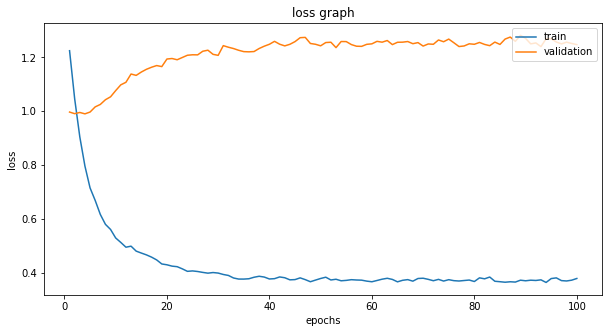

2


In [ ]:
epochs_to_show = 100
smoothing = 0.5
plt.figure(figsize=(10,5))
plt.plot(range(1,epochs_to_show+1), smooth(me_losses_train[0:epochs_to_show],smoothing), label = 'train')
plt.plot(range(1,epochs_to_show+1), smooth(mean_losses_valid[0:epochs_to_show],smoothing), label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('loss graph')
plt.show()
print(best_epoch)